Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 2D Latent Diffusion Model

In this tutorial, we will walk through the process of using the MONAI generative components package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic X-ray images of hands from the MEDNIST dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162


## Setup environment

In [10]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [14]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism, ensure_tuple
from torch.amp import GradScaler, autocast
from tqdm import tqdm

from monai.inferers import LatentDiffusionInferer
from monai.losses.adversarial_loss import PatchAdversarialLoss
from monai.losses.perceptual import PerceptualLoss
from monai.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.3rc1+14.g6c23fd06
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6c23fd06fc11667beedd0ba730d4104076a8db2d
MONAI __file__: /home/<username>/miniconda3/envs/monai1/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.15.1
pynrrd version: 1.0.0
clearml version: 1.16.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Set deterministic training for reproducibility

In [2]:
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpy_blw935


## Prepare training set data loader

Here we will download the MEDNIST dataset and prepare the training set data loader. The MEDNIST dataset contains images of different body parts, including the hand, chest, and abdomen, in grayscale format. For this tutorial, we will use only the `Hand` class. We include data augmentation performed by the `RandAffine` transformation in the data transformations.

In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:01, 46.2MB/s]                              

2024-08-06 18:30:10,594 - INFO - Downloaded: /tmp/tmpy_blw935/MedNIST.tar.gz
2024-08-06 18:30:10,672 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-08-06 18:30:10,673 - INFO - Writing into directory: /tmp/tmpy_blw935.



Loading dataset: 100%|██████████| 47164/47164 [00:12<00:00, 3671.41it/s]


### Visualise examples from the training set

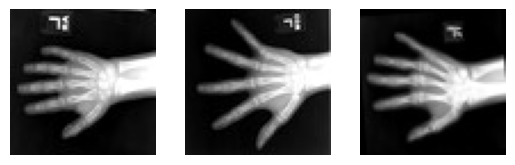

In [5]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Prepare validation set data loader

In [6]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2024-08-06 18:30:29,443 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-08-06 18:30:29,443 - INFO - File exists: /tmp/tmpy_blw935/MedNIST.tar.gz, skipped downloading.
2024-08-06 18:30:29,444 - INFO - Non-empty folder exists in /tmp/tmpy_blw935/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:01<00:00, 3671.89it/s]


## Autoencoder KL

### Define Autoencoder KL network, losses and optimiser

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images. We will also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [8]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [9]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/localek10/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 113MB/s]  
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` w

In [11]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [15]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = GradScaler("cuda")
scaler_d = GradScaler("cuda")

### Train model

It takes about ~55 min to train the model.

In [17]:
kl_weight = 1e-6
max_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

for epoch in range(max_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast("cuda", enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for _val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast("cuda", enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if _val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= _val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 2: 100%|█████████████████| 125/125 [00:51<00:00,  2.44it/s, recons_loss=0.0428, gen_loss=0, disc_loss=0]
...


Epoch 99: 100%|████████| 125/125 [00:57<00:00,  2.16it/s, recons_loss=0.0167, gen_loss=0.461, disc_loss=0.194]


epoch 100 val loss: 0.0186


### Visualise the results from the autoencoderKL

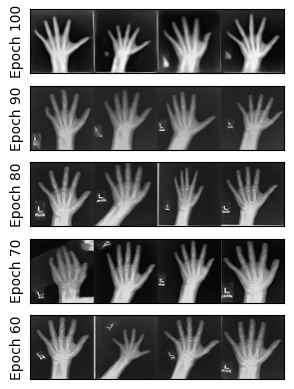

In [18]:
# Plot last 5 evaluations
val_samples = np.linspace(max_epochs, val_interval, int(max_epochs / val_interval))
nrows = min(5, len(intermediary_images))
fig, ax = plt.subplots(nrows=nrows, ncols=1, sharey=True)
ax = ensure_tuple(ax)
for image_n in range(nrows):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [19]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [21]:
with torch.no_grad():
    with autocast("cuda", enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9529204368591309


We define the inferer using the scale factor:

In [22]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

### Train diffusion model

It takes about ~80 min to train the model.

Epoch 1: 100%|██████████| 125/125 [00:34<00:00,  3.63it/s, loss=0.162]
...


Epoch 199 val loss: 0.1034


100%|██████████| 1000/1000 [00:11<00:00, 89.47it/s]


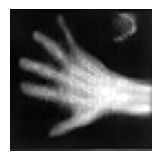

In [23]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
max_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler("cuda")

for epoch in range(max_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for _val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast("cuda", enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= _val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast("cuda", enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()

### Plot learning curves

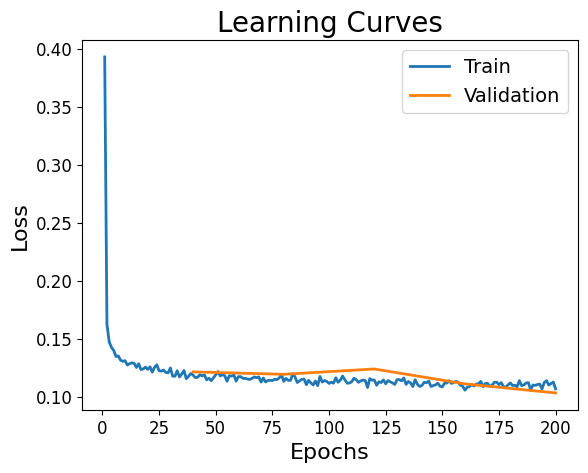

In [33]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(range(1, max_epochs + 1), epoch_losses, linewidth=2.0, label="Train")
plt.plot(range(val_interval, max_epochs + 1, val_interval), val_losses, linewidth=2.0, label="Validation")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. For every 100 steps, we store the noisy intermediary samples. In the last step, we decode all latent representations and plot how the image looks like across the sampling process.

In [25]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 16, 16))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████| 1000/1000 [00:08<00:00, 121.57it/s]


(-0.5, 639.5, 63.5, -0.5)

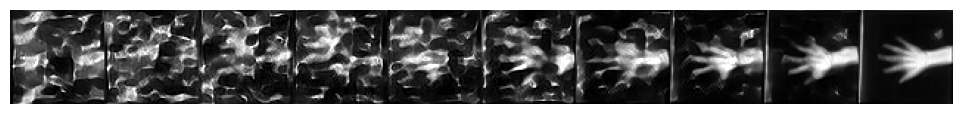

In [26]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

## Cleanup data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)